<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [207]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.plotly as py
import warnings
#warnings.filterwarnings('ignore')
import statsmodels.api as sm

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [208]:
# Load the data
house = pd.read_csv('./housing.csv')
house.shape


(1460, 81)

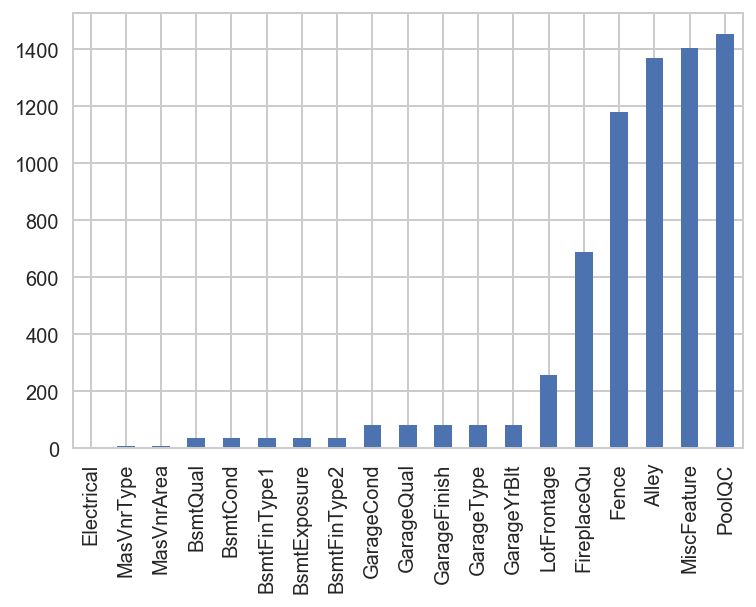

In [209]:
house.head(5)
#i see NaN, time to clean house, better check null/missing

nothing = house.isnull().sum()
#nothing contains fields with non empty cells as well
nothing = nothing[nothing>0]
nothing.sort_values(inplace=True)
nothing.plot.bar()



In [210]:
#awkward not sure if i should get rid of these house without fences/alleys
#imputing values impossible to such high no.of empty cells. will drop em

house.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)


In [212]:
house.shape
house.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


AttributeError: 'dict' object has no attribute 'shape'

In [146]:
house.columns
house['MSZoning'].value_counts()

#A, C, I can gtfo my jupyter notebook ~ non-residential.
#proceed to remove C (10) of em

house = house[house.MSZoning != 'C (all)']

#house['MSZoning'].value_counts() - doublecheck

In [147]:
# A:
house['SalePrice'].describe()

count      1450.000000
mean     181654.942069
std       79176.485241
min       37900.000000
25%      130000.000000
50%      163945.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [148]:
#dropping those pesky overall categories and non-price determining factors

house.drop(["OverallCond", "ExterQual", "ExterCond", "BsmtQual", 
         "BsmtCond", "BsmtFinType1","OverallQual", "BsmtFinType2", "KitchenQual", 
         "GarageQual", "GarageCond","HeatingQC"], axis=1, inplace=True)



In [149]:
#check 0 cells and do some fillins.
null_array = {}

for HughLaurie in house :
    if house[HughLaurie].isnull().sum() != 0:
        null_array[HughLaurie] = house[HughLaurie].isnull().sum()
        
print null_array

{'MasVnrArea': 8, 'MasVnrType': 8, 'GarageType': 79, 'LotFrontage': 259, 'GarageFinish': 79, 'GarageYrBlt': 79, 'Electrical': 1, 'BsmtExposure': 38, 'FireplaceQu': 681}


In [150]:
fillfrontage = house.LotFrontage.median()
index = house['LotFrontage'].index[house['LotFrontage'].apply(np.isnan)]

for ring in index :
    house.replace(house.LotFrontage[ring], fillfrontage, inplace=True)

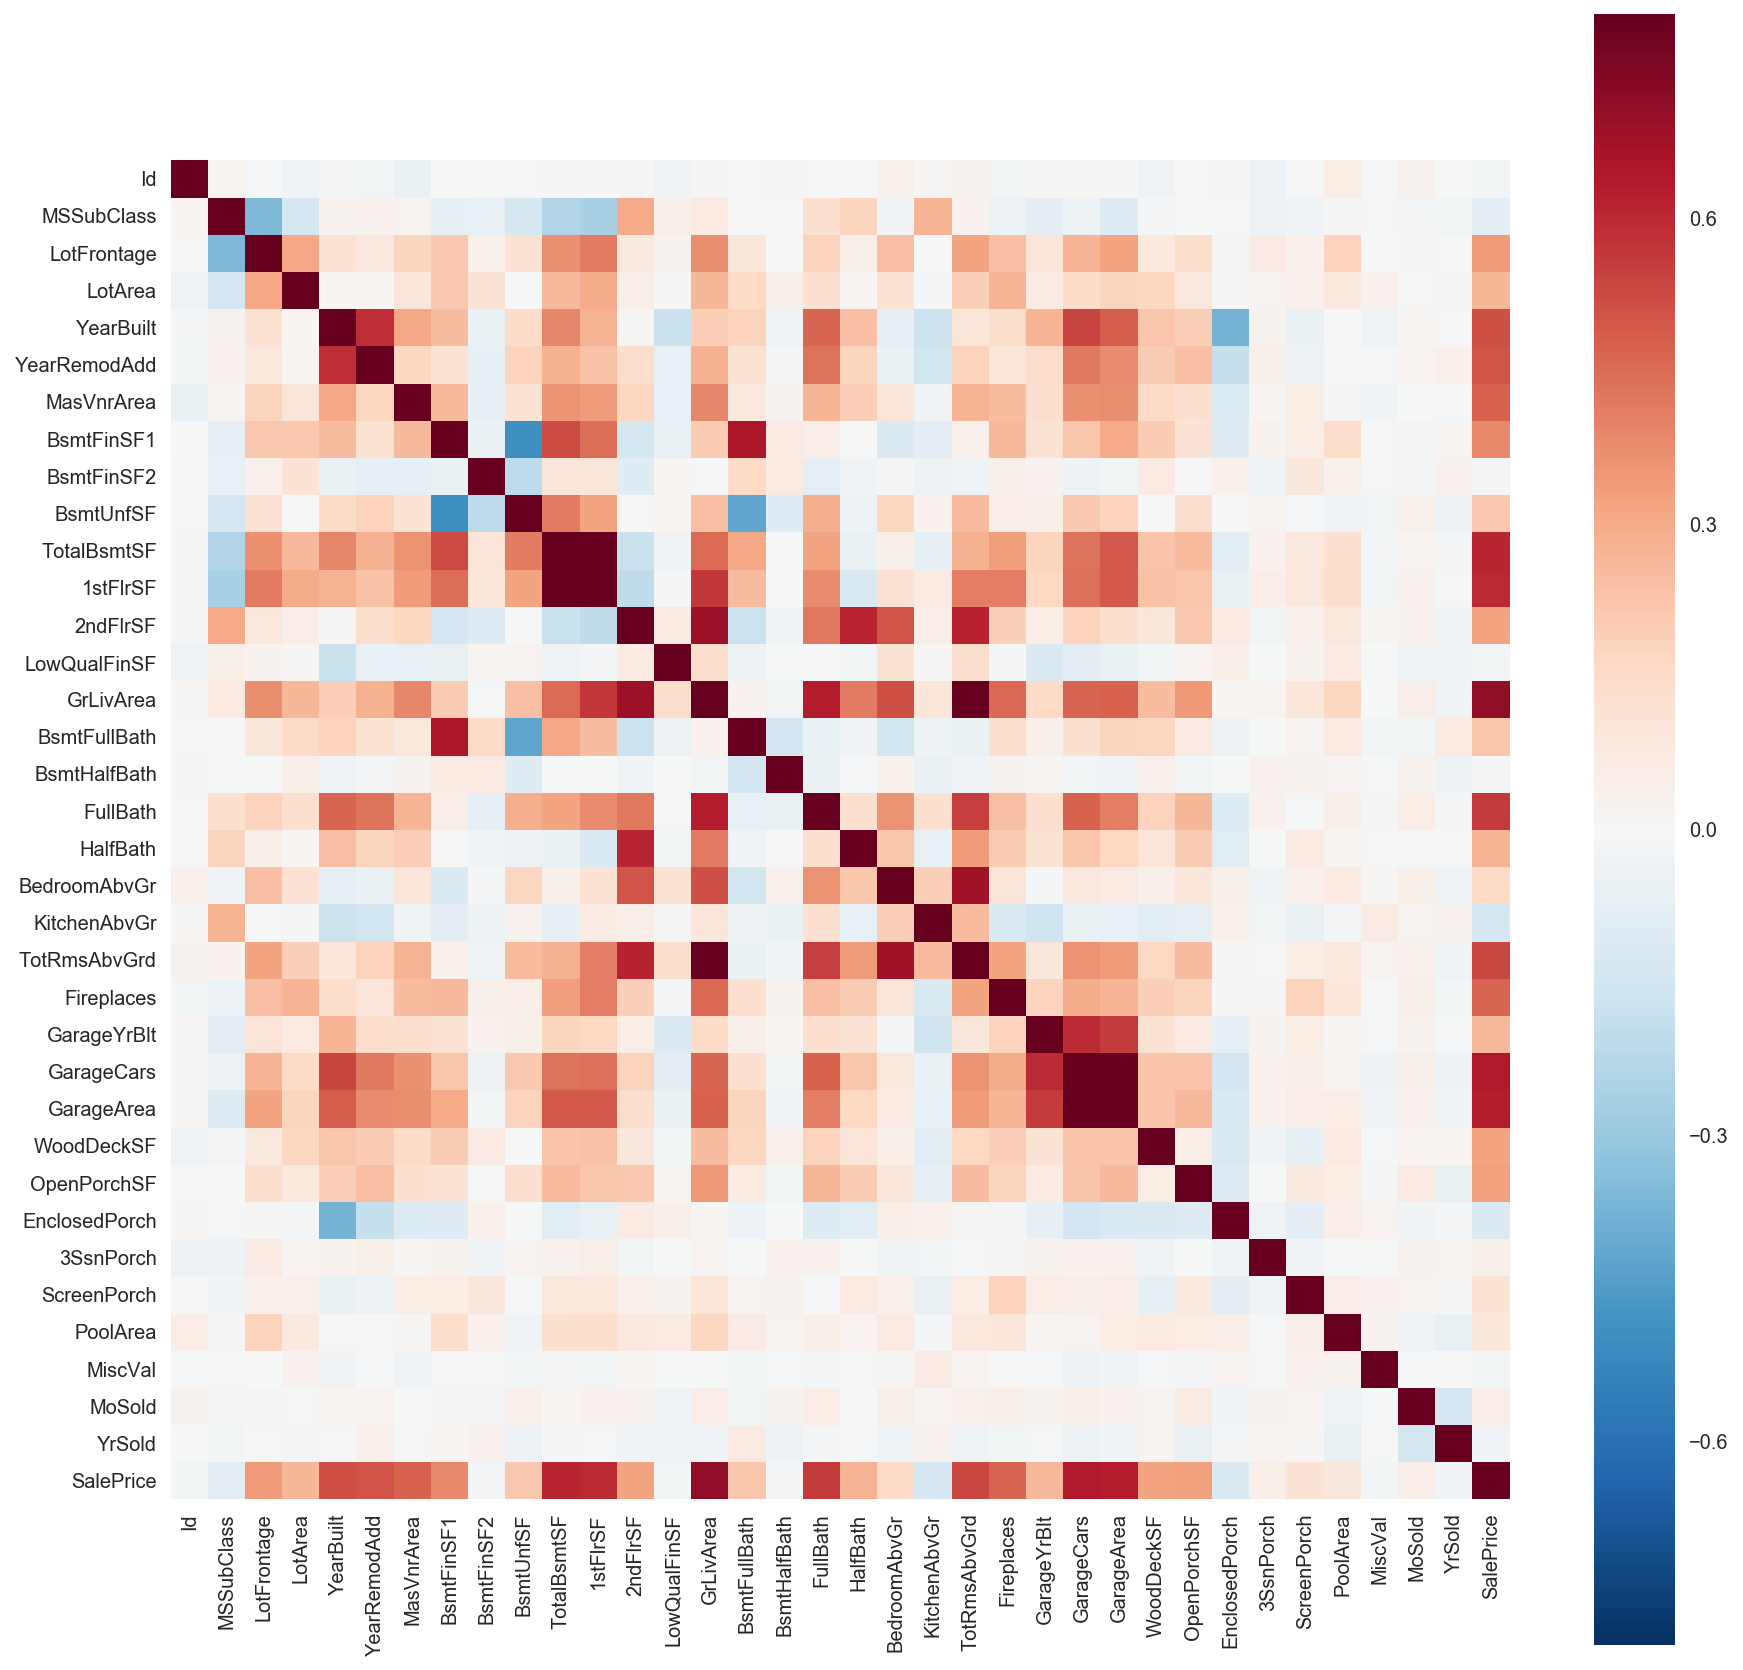

In [151]:
coreyindahouse = house.corr()
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(coreyindahouse, vmax=.8, square=True);


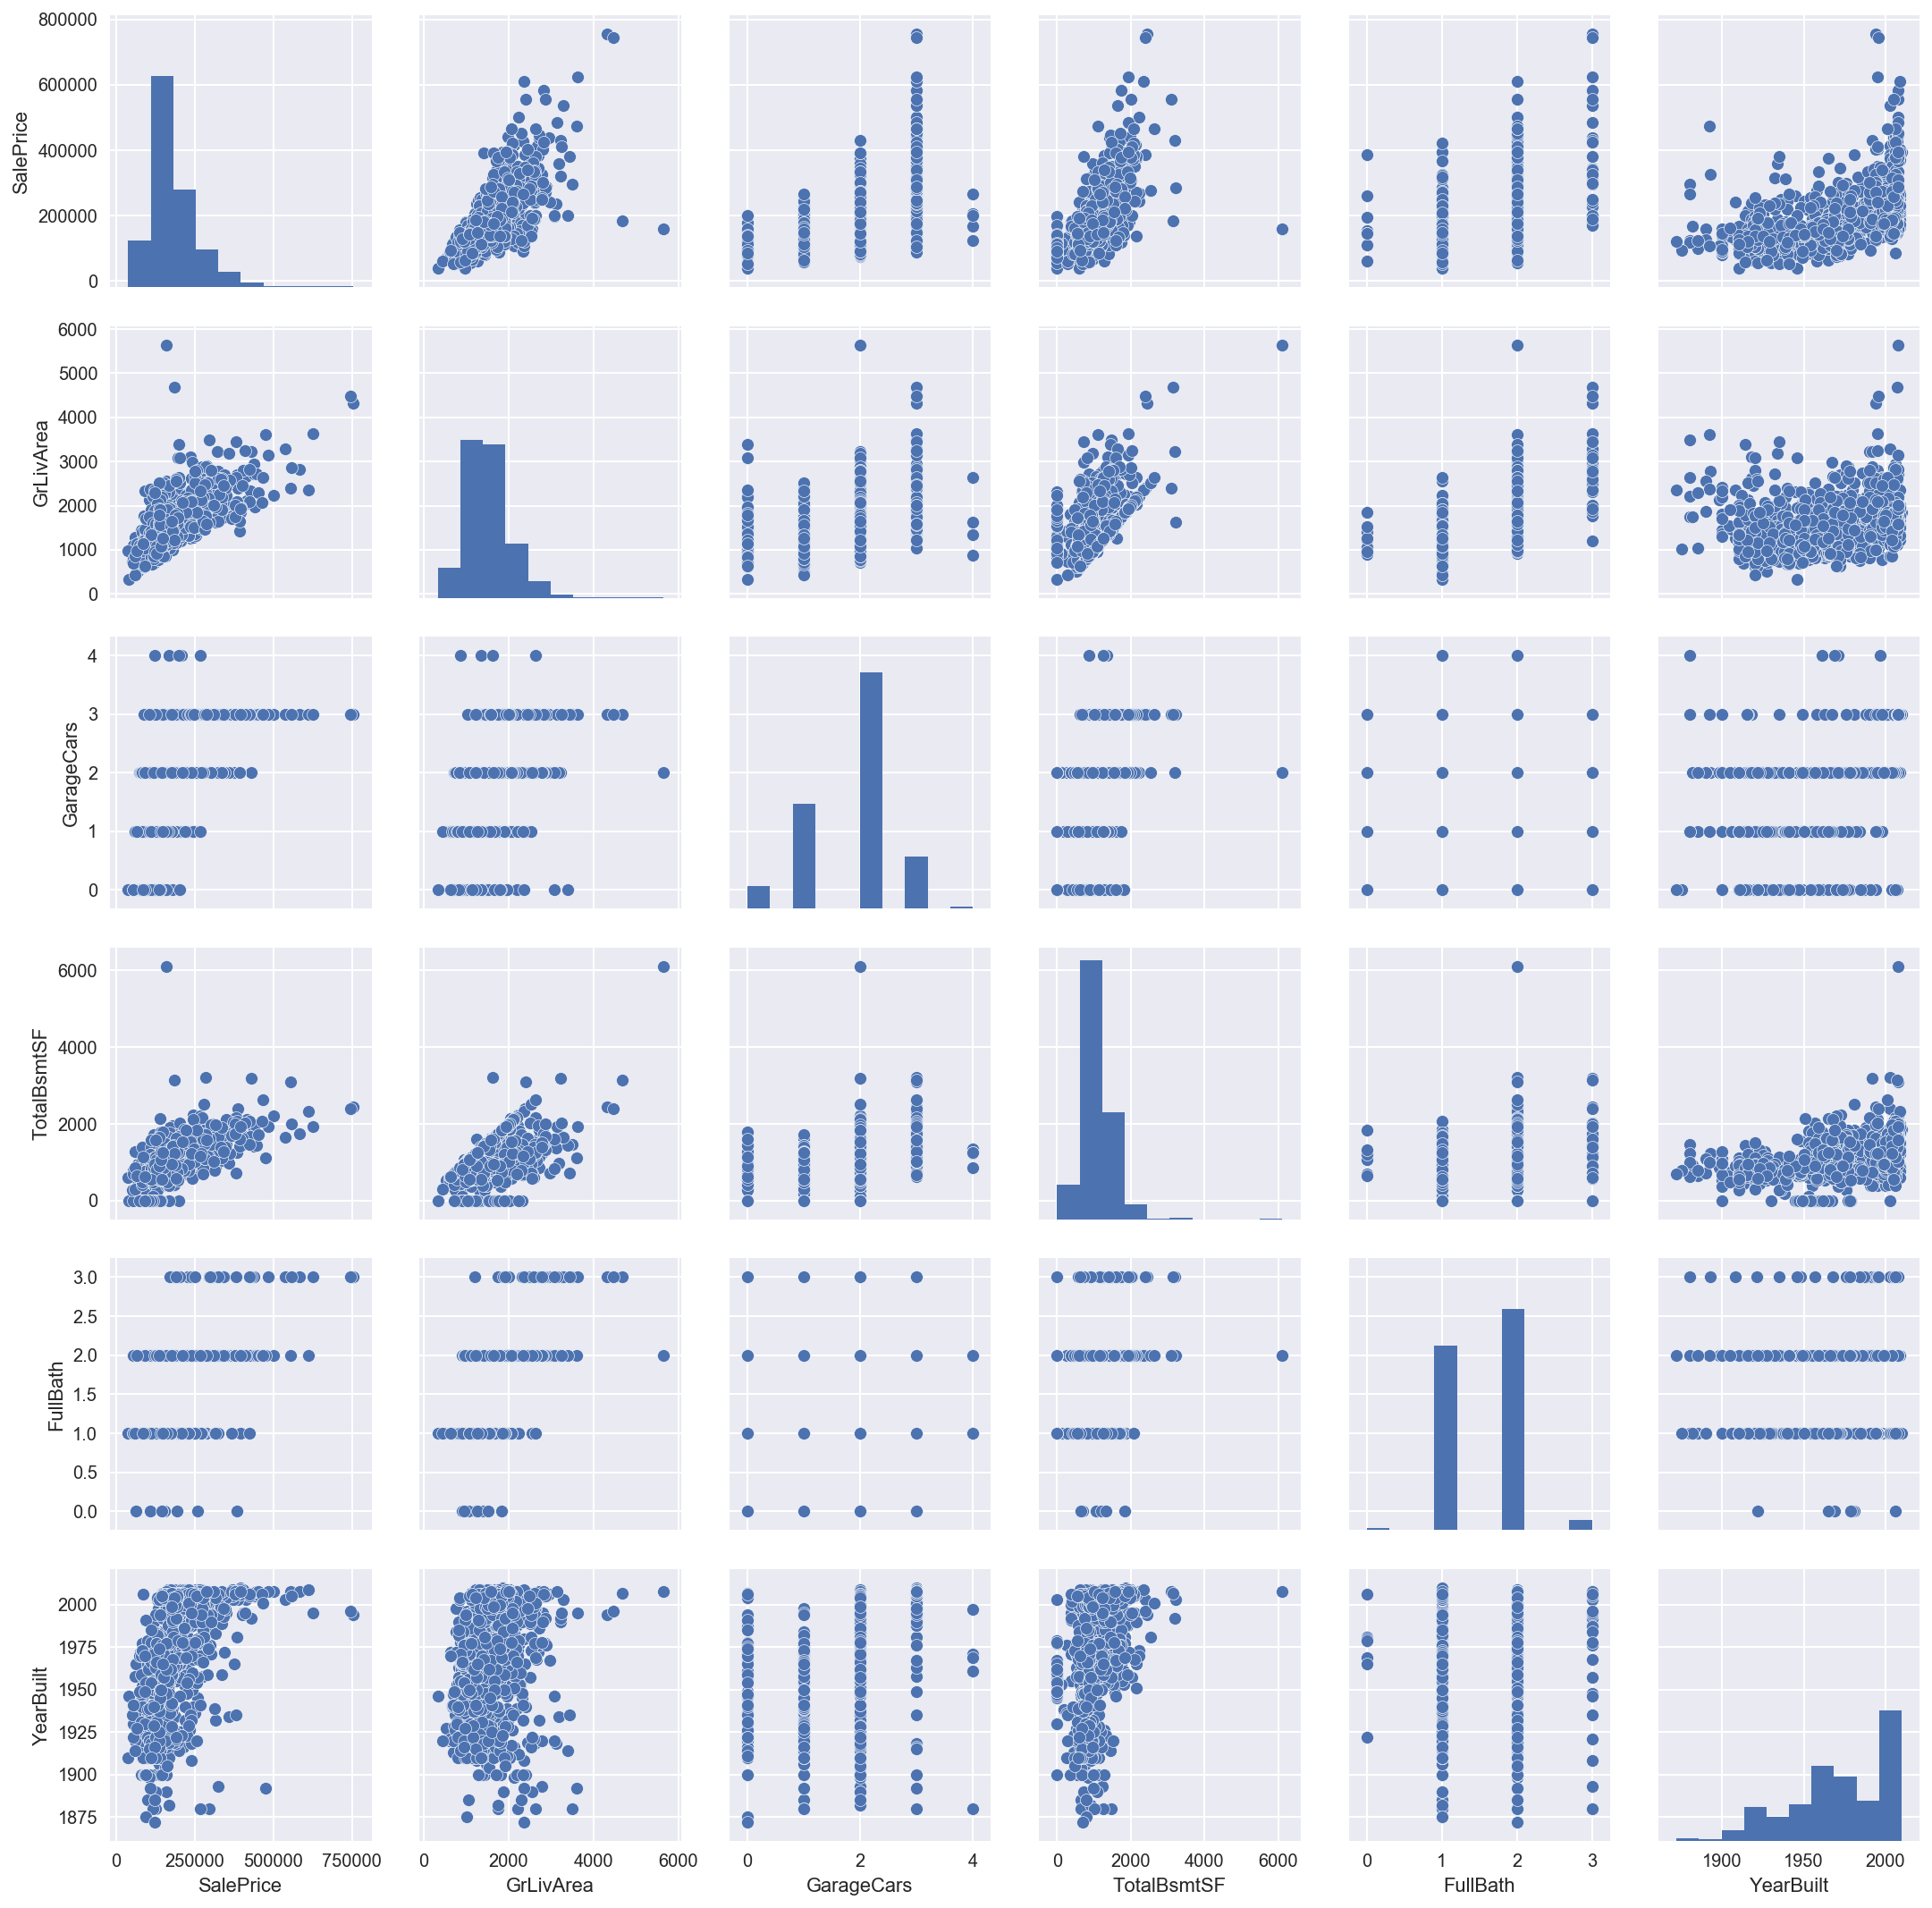

In [152]:
sns.set()
cols = ['SalePrice', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house[cols], size = 2.5)
plt.show();

In [153]:
#strong correlations for garagecars/twins as describe


In [154]:

#import patsy


In [155]:
totalmiss = house.isnull().sum().sort_values(ascending=True)
percentmiss = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing = pd.concat([totalmiss, percentmiss], axis=1, keys=['Total', 'Percent'])
missing.head(20)
#nice, we cleaned up the missing values

,Total,Percent
1stFlrSF,0,0.0
2ndFlrSF,0,0.0
3SsnPorch,0,0.0
BedroomAbvGr,0,0.0
BldgType,0,0.0
BsmtExposure,0,0.0
BsmtFinSF1,0,0.0
BsmtFinSF2,0,0.0
BsmtFullBath,0,0.0
BsmtHalfBath,0,0.0


In [156]:
#split home to seperate continuous columns from categorical ones, 2 more dataframes

cont= ['LotFrontage', "LotArea", "YearBuilt", "YearRemodAdd", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
             "TotalBsmtSF", "1stFlrSF", "2ndFlrSF","LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath",
             "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "GarageYrBlt", 
             "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch",
             "PoolArea", "MoSold"]
cat= ['MSZoning', "Street", "LotShape", "LandContour", "LotConfig", "LandSlope", "Neighborhood", 
            "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "Foundation", 
            "BsmtExposure", "Functional", "GarageType"]

house_cat = house.loc[:, cat]
house_cont = house.loc[:, cont]


house_cont.head(5) #you know you are right when all you see are numbers
house_cont.dtypes

LotFrontage      float64
LotArea            int64
YearBuilt          int64
YearRemodAdd       int64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
GarageYrBlt      float64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MoSold             int64
dtype: object

In [157]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mm = MinMaxScaler()
ss = StandardScaler()

In [158]:
house_cont.dtypes
# house_cont.drop('LotFrontage', axis=1, inplace=True) damnstupid

LotFrontage      float64
LotArea            int64
YearBuilt          int64
YearRemodAdd       int64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
GarageYrBlt      float64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MoSold             int64
dtype: object

In [172]:
#fit and scale the continuous values

cont_new = pd.DataFrame(ss.fit_transform(house_cont))
cont_temp = pd.concat([cont_new, house["YrSold"]], axis=1)

cont_test = cont_temp[cont_temp.YrSold == 2010]
cont_train = cont_temp[cont_temp.YrSold != 2010]

cont_test.drop(["YrSold"], axis=1, inplace=True)
cont_train.drop(["YrSold"], axis=1, inplace=True)
cont_train.reset_index(drop=True, inplace=True)
cont_test.reset_index(drop=True, inplace=True)

#print cont_test

#same for categorical values

cat_dum = pd.get_dummies(cat, drop_first=True)

cat_dum.reset_index(drop=True, inplace=True)
cat_temp = pd.concat([cat_dum, house["YrSold"]], axis=1)

cat_test = cat_temp[cat_temp.YrSold == 2010]
cat_train = cat_temp[cat_temp.YrSold != 2010]

cat_test.drop(["YrSold"], axis=1, inplace=True)
cat_train.drop(["YrSold"], axis=1, inplace=True)
cat_train.reset_index(drop=True, inplace=True)
cat_test.reset_index(drop=True, inplace=True)

#merge back the cont + cat for test/train

X_train = pd.concat([cat_train, cont_train], axis=1)
X_test = pd.concat([cat_test, cont_test], axis=1)
y_train = house.SalePrice[house.YrSold != 2010]
y_train.reset_index(drop=True, inplace=True)
y_test = house.SalePrice[house.YrSold == 2010]
y_test.reset_index(drop=True, inplace=True)

y_train.shape
#X_train.shape

(1278,)

In [174]:
#now we train the before 2010 dataset cont/cat, least squares model

model = sm.OLS(y_train,X_train).fit()
y_pred = model.predict(X_test)
results.params

ValueError: On entry to DLASCL parameter number 5 had an illegal value

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [4]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: